In [ ]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
from scipy.spatial import distance
from operator import itemgetter
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#SET SEEDS
np.random.seed(24)
random.seed(24)
torch.manual_seed(24)

In [ ]:
movies_data_path = '/content/drive/MyDrive/Colab Notebooks/ee541/Project/movies_data.hd5'
movies_data = h5py.File(movies_data_path,'r')

dataset_path = '/content/drive/MyDrive/Colab Notebooks/ee541/Project/generated_data.hd5'
dataset  = h5py.File(dataset_path,'r')

cosine_weights_path = '/content/drive/MyDrive/Colab Notebooks/ee541/Project/cosine_weights.hd5'
cosine_weights = h5py.File(cosine_weights_path, "r")

In [ ]:
# movies_data_path = '/content/drive/MyDrive/Project/movies_data.hd5'
# movies_data = h5py.File(movies_data_path,'r')

# dataset_path = '/content/drive/MyDrive/Project/generated_data.hd5'
# dataset  = h5py.File(dataset_path,'r')

# cosine_weights_path = '/content/drive/MyDrive/Project/cosine_weights.hd5'
# cosine_weights = h5py.File(cosine_weights_path, "r")

In [ ]:
movies_vectors = movies_data['metadata'][:]
movies_id = movies_data['id'][:]
movies_title = movies_data['title'][:]

x_data = dataset['x_data'][:]
y_data = dataset['y_label'][:]
inp_combination = dataset['combination'][:]

w = cosine_weights['w'][:]

In [ ]:
w = torch.from_numpy(w)
movies_vectors = torch.from_numpy(movies_vectors)
x_data = torch.from_numpy(x_data)
y_data = torch.from_numpy(y_data)
inp_combination = torch.from_numpy(inp_combination)

In [ ]:
x_data,y_data,inp_combination = shuffle(x_data, y_data, inp_combination, random_state = 24)

In [ ]:
#Test-Train-Validation Set
train_x = x_data[:99000]
train_id = inp_combination[:99000]
train_y = y_data[:99000]

validation_x = x_data[99000:]
validation_id = inp_combination[99000:]
validation_y = y_data[99000:]

In [ ]:
def get_title(id):
  title_list = []
  for i in id:
    ind = np.where(movies_id == i)
    title = title = str(movies_title[ind])[2:-1]
    title_list.append(title) 
  return title_list

In [ ]:
def get_recommendation(combined_vector, id):
  vec = combined_vector.reshape((1,409))
  movie_list = {}
  for i in range(6716):
    if( (movies_id[i] != id[0]) and (movies_id[i] != id[1]) and (movies_id[i] != id[2])):
      mov = movies_vectors[i].reshape((409,1))
      cs = distance.cosine(vec,mov,w)
      title = str(movies_title[i])[2:-1]
      movie_list[title] = [cs,movies_id[i]]
  movie_list = dict(sorted(movie_list.items(), key = itemgetter(1), reverse = False)[:5])
  return movie_list

In [ ]:
def output_recommendation(v,id):
  m = get_recommendation(v,id)
  names = get_title(id)
  print("============================")
  print('For movies :' ,names[0],names[1],names[2])
  print("Recommendation is: ",m.keys())

In [ ]:
train_dataset = TensorDataset(train_x,train_y,train_id)
validation_dataset = TensorDataset(validation_x, validation_y, validation_id)

In [ ]:
num_inputs = 409*3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(num_inputs, 1000)
        self.hidden2 = nn.Linear(1000, 800)
        self.output = nn.Linear(800, 409)
  

    def forward(self, x):
        x = self.hidden1(x) 
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)
        return x

model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
model.to(device);

print(device)

cuda:0


In [ ]:
summary(model, (1, 1, num_inputs))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 1000]       1,228,000
            Linear-2            [-1, 1, 1, 800]         800,800
            Linear-3            [-1, 1, 1, 409]         327,609
Total params: 2,356,409
Trainable params: 2,356,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 8.99
Estimated Total Size (MB): 9.01
----------------------------------------------------------------


In [ ]:
#Loading the test and train dataset
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=2)
val_loader = DataLoader(validation_dataset, batch_size=1,shuffle=False, num_workers=2)

In [ ]:
def train_model(learning_rate, wd, epochs, filename="model.pt"): 
  loss_func = nn.MSELoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=wd)

  num_epochs  = epochs

  # for generating plots
  loss_list = []
  iteration_list = []
  similarity_list = []

  count = 0
  for epoch in range(num_epochs):

    for combined_vec,recommended_vec,idlist in train_loader:
      count += 1
      model.train()

      # Transfering images and labels to GPU if available
      combined_vec, recommended_vec = combined_vec.to(device) , recommended_vec.to(device).float()
      train = combined_vec.view(-1, num_inputs)

      # Forward pass 
      outputs = model(train.float())
      loss = loss_func(recommended_vec, outputs)
      
      # back-prop
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()

      if not(count % 1000):
        with torch.no_grad():
          cosine_distance = []
          c = 0
          for combined_vec,recommended_vec,idlist in val_loader:
            c+=1
            combined_vec, recommended_vec = combined_vec.to(device) , recommended_vec.to(device).float()
            model.eval()

            outputs = model(combined_vec.float()).cpu()
            predictions = outputs[:]

            np_preds = predictions.cpu().detach().numpy()
            rvec = recommended_vec.cpu().detach().numpy()

            if(c <= 5):
              id_list_np = idlist.cpu().detach().numpy()
              output_recommendation(np_preds,id_list_np[0])
              
            cs1 = distance.cosine(np_preds,rvec.T, w)
            cosine_distance.append(cs1)

                
            avg_cs = sum(cosine_distance)  / len(cosine_distance)
            
          loss_list.append(loss.cpu().data)
          iteration_list.append(count)
          similarity_list.append(avg_cs)

          print(f'Epoch: {epoch+1:02d}, Iteration: {count:5d}, Loss: {loss.data:.4f}') 
  
  torch.save(model,filename)   
  print('Finished Training')

  return loss_list,iteration_list,similarity_list

In [ ]:
#Configuration 1: lr=0.004 wd = 1e-10 
c1_loss, c1_iter, c1_dist = train_model(0.004,1e-10,10,"config_1.pt")

For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['Snowtown', 'Children of the Corn', 'Shark Swarm', 'Wrecker', 'Found'])
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Growing Op', "Love's Complicated", 'A Little Help', 'Be Somebody', 'Paper Heart'])
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Man vs. Snake', 'Helvetica', 'With Great Power: The Stan Lee Story', 'Vegucated', 'Minimalism: A Documentary About the Important Things'])
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['A Little Help', 'Christmas Town', 'Growing Op', 'A Very Merry Mix-Up', 'Meet the Browns'])
For movies : 'Song One' 'Prowl' 'Marauders'
Recommendation is:  dict_keys(['Snowtown', 'Animal Kingdom', 'Swerve'

In [ ]:
#Configuration 2: lr=0.0005 wd = 1e-10 
c2_loss, c2_iter, c2_dist = train_model(0.0005,1e-10,10,"config_2.pt")

For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['Snowtown', 'Shark Swarm', 'Children of the Corn', 'The Woman in Black', 'Found'])
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Growing Op', "Love's Complicated", 'A Little Help', 'The Edge of Seventeen', 'Be Somebody'])
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Man vs. Snake', 'Helvetica', 'Minimalism: A Documentary About the Important Things', 'With Great Power: The Stan Lee Story', 'Vegucated'])
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['Listen Up Philip', 'The Edge of Seventeen', 'Foster', 'Speech & Debate', "Madea's Big Happy Family"])
For movies : 'Song One' 'Prowl' 'Marauders'
Recommendation is:  dict_keys(['Snowt

In [ ]:
#Configuration 2: lr=0.0001 wd = 1e-10 
c3_loss, c3_iter, c3_dist = train_model(0.0001,0,10,"config_3.pt")

For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['Wrecker', 'Shark Swarm', 'Snowtown', 'Children of the Corn', 'The Girl Next Door'])
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Growing Op', "Love's Complicated", 'The Edge of Seventeen', 'A Little Help', 'Camp Takota'])
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Man vs. Snake', 'With Great Power: The Stan Lee Story', 'Vegucated', 'Helvetica', 'Minimalism: A Documentary About the Important Things'])
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['Foster', 'A Little Help', 'A Christmas Wish', 'Speech & Debate', 'The Edge of Seventeen'])
For movies : 'Song One' 'Prowl' 'Marauders'
Recommendation is:  dict_keys(['Snowtown', 'An

In [ ]:
#Configuration 2: lr=0.0001 wd = 1e-10 
c4_loss, c4_iter, c4_dist = train_model(1e-5,0,10,"config_4.pt")

For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['Children of the Corn', 'Shark Swarm', 'Snowtown', 'The Woman in Black', 'Found'])
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Music Within', 'The Edge of Seventeen', 'Listen Up Philip', 'Kabluey', 'I Want Candy'])
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Notes on Blindness', 'Super High Me', 'The Overnighters', 'Man vs. Snake', 'An Honest Liar'])
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['A Little Help', 'Speech & Debate', 'Growing Op', 'The Edge of Seventeen', 'Music Within'])
For movies : 'Song One' 'Prowl' 'Marauders'
Recommendation is:  dict_keys(['Snowtown', 'Children of the Corn', 'Mischief Night', 'Found', 'Sha

Analysis and Plots

In [ ]:
def mse_db(arr):
  k = [10*np.log10(i) for i in arr]
  return k

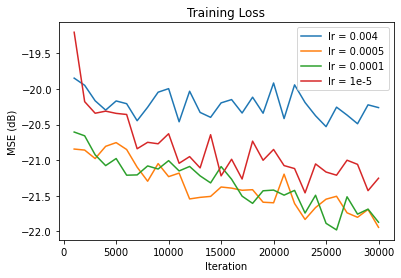

In [ ]:
plt.plot(c1_iter, mse_db(c1_loss), label = "lr = 0.004")
plt.plot(c2_iter, mse_db(c2_loss), label = "lr = 0.0005")
plt.plot(c3_iter, mse_db(c3_loss), label = "lr = 0.0001")
plt.plot(c4_iter, mse_db(c4_loss), label = "lr = 1e-5")
plt.xlabel("Iteration")
plt.ylabel("MSE (dB)")
plt.title("Training Loss")
plt.legend()

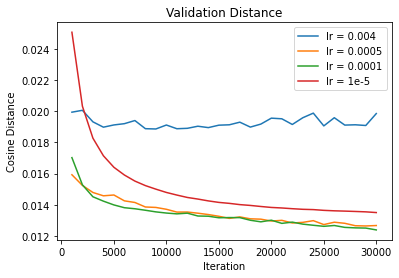

In [ ]:
plt.plot(c1_iter, c1_dist, label = "lr = 0.004")
plt.plot(c2_iter, c2_dist, label = "lr = 0.0005")
plt.plot(c3_iter, c3_dist, label = "lr = 0.0001")
plt.plot(c4_iter, c4_dist, label = "lr = 1e-5")
plt.xlabel("Iteration")
plt.ylabel("Cosine Distance")
plt.title("Validation Distance")
plt.legend()

In [ ]:
c=0
for i,j,k in val_loader:
  c+=1
  if(c<=5):
    x=k.numpy()
    print(x)
    output_recommendation(j,x[0])
  else:
    break

[[324986. 298093.  18635.]]
For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['The Girl Next Door', 'Wrecker', 'Snowtown', 'Shuttle', 'Shark Swarm'])
[[73108. 73565. 12133.]]
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Birds of America', 'The Edge of Seventeen', 'Kabluey', 'Norman', 'Summer of 8'])
[[222724.  62764. 222724.]]
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Man vs. Snake', 'I Am Chris Farley', 'With Great Power: The Stan Lee Story', 'Bridegroom', 'I Am Evel Knievel'])
[[ 84180. 369883.  46909.]]
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['Are We Done Yet?', 'Speech & Debate', 'True Confessions of a Hollywood Starlet', 'The Angriest Man in Brooklyn', 'Foster'])

In [ ]:
model1 = torch.load("config_3.pt")
i,j,k = 0,1,2
combined_vec = torch.cat((movies_vectors[i],movies_vectors[j],movies_vectors[k]),0)
combined_vec = combined_vec.to(device)
model1.eval()

outputs = model1(combined_vec.float()).cpu()
predictions = outputs[:]
np_preds = predictions.cpu().detach().numpy()
output_recommendation(np_preds,[movies_id[i],movies_id[j],movies_id[k]])

torch.Size([409])
torch.Size([409])
For movies : 'Black Gold' 'Freedom Writers' 'Code Name: The Cleaner'
Recommendation is:  dict_keys(['Edwin Boyd: Citizen Gangster', 'Dope', 'Animal Kingdom', 'Casino Jack', 'Graduation'])


In [ ]:
model2 = torch.load("config_2.pt")
i,j,k = 0,1,2
combined_vec = torch.cat((movies_vectors[i],movies_vectors[j],movies_vectors[k]),0)
combined_vec = combined_vec.to(device)
model2.eval()

outputs = model1(combined_vec.float()).cpu()
predictions = outputs[:]
np_preds = predictions.cpu().detach().numpy()
output_recommendation(np_preds,[movies_id[i],movies_id[j],movies_id[k]])

For movies : 'Black Gold' 'Freedom Writers' 'Code Name: The Cleaner'
Recommendation is:  dict_keys(['Edwin Boyd: Citizen Gangster', 'Dope', 'Animal Kingdom', 'Casino Jack', 'Graduation'])


In [ ]:
model3 = torch.load("config_3.pt")
i,j,k = 0,1,2
combined_vec = torch.cat((movies_vectors[i],movies_vectors[j],movies_vectors[k]),0)
combined_vec = combined_vec.to(device)
model3.eval()

outputs = model1(combined_vec.float()).cpu()
predictions = outputs[:]
np_preds = predictions.cpu().detach().numpy()
output_recommendation(np_preds,[movies_id[i],movies_id[j],movies_id[k]])

For movies : 'Black Gold' 'Freedom Writers' 'Code Name: The Cleaner'
Recommendation is:  dict_keys(['Edwin Boyd: Citizen Gangster', 'Dope', 'Animal Kingdom', 'Casino Jack', 'Graduation'])


In [ ]:
numbers = [i for i in range(6716)]
indices_list = shuffle(numbers)

for a in range(10):
  i,j,k = random.sample(indices_list,3)
  combined_vec = torch.cat((movies_vectors[i],movies_vectors[j],movies_vectors[k]),0)
  combined_vec = combined_vec.to(device)
  model.eval()

  outputs = model(combined_vec.float()).cpu()
  predictions = outputs[:]
  np_preds = predictions.cpu().detach().numpy()
  output_recommendation(np_preds,[movies_id[i],movies_id[j],movies_id[k]])

For movies : 'Conspiracy' 'The American Scream' "Henry Gamble's Birthday Party"
Recommendation is:  dict_keys(['Notes on Blindness', 'The Overnighters', 'Kidnapped for Christ', 'Killing Lincoln', 'Five Star'])
For movies : 'Love Birds' 'Atonement' 'Laggies'
Recommendation is:  dict_keys(['A Little Help', 'American High School', 'That Awkward Moment', 'Standby', 'Table for Three'])
For movies : 'ABCs of Death 2.5' 'Last Days in the Desert' 'Cougars, Inc.'
Recommendation is:  dict_keys(['13 Cameras', 'The Windmill Massacre', "Devil's Diary", 'The Battery', 'Buzzard'])
For movies : 'The Son of No One' 'Inception' 'Drive'
Recommendation is:  dict_keys(['Animal Kingdom', 'Swerve', 'The Diplomat', 'Extortion', 'Snowtown'])
For movies : 'Wuthering Heights' 'Mother and Child' 'DeadHeads'
Recommendation is:  dict_keys(["Love's Complicated", 'The Dog Lover', 'Growing Op', 'Burning Man', 'Paper Heart'])
For movies : 'Pirates of the Caribbean: Dead Men Tell No Tales' 'Swinging with the Finkels' 'S

In [ ]:
#Storing the weights and bias of the first model
model = torch.load("config_3.pt")
params = []
for val in model.parameters(): 
  params.append(val.cpu().detach().numpy())

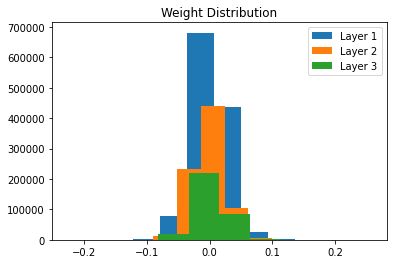

In [ ]:
plt.hist(params[0].reshape(1227000), label = "Layer 1")
plt.hist(params[2].reshape(800000),label = "Layer 2")
plt.hist(params[4].reshape(327200),label = "Layer 3")
plt.legend()
plt.title("Weight Distribution")
  
plt.show()

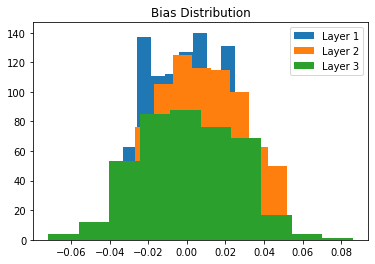

In [ ]:
plt.hist(params[1].reshape(1000), label ="Layer 1" )
plt.hist(params[3].reshape(800), label = "Layer 2")
plt.hist(params[5].reshape(409), label ="Layer 3")
plt.title("Bias Distribution")
plt.legend()
  
plt.show()